# Python Libraries in this Notebook
[Return to Table of Contents](#Table-of-Contents)

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '1' # Resolves warning on KMeans memory leak. Needs to be done before importing KMeans.

#### Note on the above cell:
Note that on Windows computers you may get a memory leak warning. To solve this use the following solution: https://stackoverflow.com/questions/69596239/how-to-avoid-memory-leak-when-dealing-with-kmeans-for-example-in-this-code-i-am

A memory leak is a situation in computer science that occurs when a reseource that was initailly used by a computer is not being released by the system after it is not needed.

In [2]:
# imports
import pandas as pd
import numpy as np
from numpy import unique

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans # K-Means and DBSCAN algorithms
from sklearn.feature_extraction.text import TfidfVectorizer # Vectorization Functions

import nltk # Natural Langage Toolkit
from nltk import word_tokenize, pos_tag # Tokenizer and Parts of Speech Tags
from nltk.tokenize import RegexpTokenizer # Tokenizer
from nltk.stem import WordNetLemmatizer # Lemmitization
from nltk.corpus import stopwords, wordnet # Stopwords and POS tags
#nltk.download #(One time to download 'stopwords')
#nltk.download # (One time to download 'punkt')

# Defining Notebook Default Settings

In [3]:
pd.set_option('display.max_colwidth', None) # PD has a limit of 50 characters.  Removes limit and uses the full text.
pd.options.display.float_format = "{:.4f}".format # Sets PD to displays float numbers as 4 decimal places.
plt.style.use('tableau-colorblind10') # Sets MatPlotLib default color style to 'tableau-colorblind10'
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] # Colors cycling.

# Data Loading

In [4]:
# Load data as dataframe.
df = pd.read_csv('./input_data/disney_plus_titles.csv')
#df = pd.read_csv('./input_data/ufo_scrubbed.csv')
#df = pd.read_csv('./input_data/bible_data_set.csv')

## Exploratory Data Analysis (EDA)
[Return to Table of Contents](#Table-of-Contents)

Using the functions .info(), and if the data has numerical columns use the .describe(), .hist(), .pairplot(), and .corr() are always useful to explore and better understand your data. These functions always provide useful information regardless of the type of analysis or model that you will be working on. They can help in identifying issues that can be addressed thru data cleaning (e.g., unexpected feature datatype, outliers, ), identifying features that may be worth visualizing in plots and charts, identify features that can be used for clustering or that may have clusters, identify features that have outliers, and help in developing drill down and define the focus of an analysis.

In [5]:
df.info() # Info on columns.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1368 entries, 0 to 1367
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       1368 non-null   object
 1   type          1368 non-null   object
 2   title         1368 non-null   object
 3   director      928 non-null    object
 4   cast          1194 non-null   object
 5   country       1193 non-null   object
 6   date_added    1365 non-null   object
 7   release_year  1368 non-null   int64 
 8   rating        1366 non-null   object
 9   duration      1368 non-null   object
 10  listed_in     1368 non-null   object
 11  description   1368 non-null   object
dtypes: int64(1), object(11)
memory usage: 128.4+ KB


# Natural Language Processing (NLP)

The objective of NLP is to convert the text to a mathematical and numerical representation that can be understood by a computer to perform calculations. To accomplish this there are various models that can be used. In this example we will use the Bag of Words (BoW) model which is a matrix of the vecstors (i.e., numerical reperesentation) of each token (i.e., word, or combination of words) and where each token is a dimension within the data. In the BoW model, not all words are reprented and many words (e.g., stopwords) are removed. The matrix created is called a [sparse matrix](https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html). Each column in the matrix represents a vector for each dimension (e.g., token).

# Stopwords
[Return to Table of Contents](#Table-of-Contents)

Stop words are defined as words that occur too often in the corpus and do not have significant contribution to the model, providing insights, or extracting meaning. In a language these can include words that occur too often. NLP libraries (e.g., NLTK, Scikit-learn) typically have a list of predefined stop words. NLP tools can use a list of global stop words applied during text cleaning tasks as well as could also allow users submit custom list of stop words that may be industry specific. The use of stop words (custom or otherwise) need to be documented as removing important words to the corpus may either introduce errors, biases, or give the appearance of bias.

In [27]:
# STOPWORDS USED FOR SAFETY OCCURRENCE CORPUS.
# Stopwords to add need to be evaluated by a SME familiar with the corpus.
stopwords_to_add = ['building', 'employee', # Example: ['building', 'employee','worker']
                    'see', 'details', 'details', 'advisory'] # Disney dataset has these words in many descriptions.

stopwords_custom = stopwords.words('english') + [x.lower() for x in stopwords_to_add]
#print(stopwords_custom) # Comment out to see list of stopwords_custom before removing the 'no'.

# In some cases you want to consider 2-grams especially with the word no.
# For example 'no fire'.  Removing the word no from the stopwords list allows this to occur.
remove_as_stopword = ['no', 'not']
stopwords_custom = list(filter(lambda w: w not in remove_as_stopword, stopwords_custom))
print(stopwords_custom)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', 'very',

In [28]:
# The stopword list for NLTK and SciKit learn vary.
# Recommended to review them to make sure there are no unintended consequences.
# Note that stopwords can also be called in the SciKit learn vectorization functions (e.g., TFIDFvectorizer)
# This can cause to inadvertently apply stopwords there as well.

# Text Normalization Functions
[Return to Table of Contents](#Table-of-Contents)

During text normalization various task can be performed which include but not limited to applying lower case, removing numbers and special characters, removing stop words, and applying lemmatization and/or stemming both which reduces words to their root. 

Documentation:
- NLTK Library: https://www.nltk.org/
- NLTK WordnetLemmatizer: https://www.nltk.org/_modules/nltk/stem/wordnet.html
- NLTK Porterstemmer: https://www.nltk.org/howto/stem.html

Other References:
- Guide for dealing with text data predictive in Python: https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/

Lemmatization and Stemming References
- https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
- https://www.analyticsvidhya.com/blog/2022/06/stemming-vs-lemmatization-in-nlp-must-know-differences/
- https://212digital.medium.com/what-is-lemmatization-and-stemming-in-nlp-e25e142332c4

In [29]:
# Normalization of text. 
def text_normalization(text, word_reduction_method):
    text = str(text) # Convert narrative to string.
    df = pd.DataFrame({'': [text]}) # Converts narrative to a dataframe format use replace functions.
    df[''] = df[''].str.lower() # Covert narrative to lower case.
    df[''] = df[''].str.replace(r"\d+", " ", regex = True) # Remove numbers
    df[''] = df[''].str.replace(r"[^\w\s]", " ", regex = True) # Remove special characters
    df[''] = df[''].str.replace(r"_", " ", regex = True) # Remove underscores characters
    df[''] = df[''].str.replace(r'\s+', ' ', regex = True) # Replace multiple spaces with single
    text = str(df[0:1]) # Extracts narrative from dataframe.
    tokenizer = RegexpTokenizer(r'\w+') # Tokenizer.
    tokens = tokenizer.tokenize(text) # Tokenize words.
    filtered_words = [w for w in tokens if len(w) > 1 if not w in stopwords_custom] # Note remove words of 1 letter only. Can increase to higher value as needed.
    if word_reduction_method == 'Lemmatization':
        lemmatizer = WordNetLemmatizer()
        reduced_words=[lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in filtered_words] # Lemmatization.  The second argument is the POS tag.
    if word_reduction_method == 'Stemming':
        stemmer = PorterStemmer() # Stemming also could make the word unreadable but is faster than lemmatization.
        reduced_words=[stemmer.stem(w) for w in filtered_words]
    return " ".join(reduced_words) # Join words with space.

def get_wordnet_pos(word): # Reference: https://www.machinelearningplus.com/nlp/lemmatization-examples-python/#wordnetlemmatizer
    #"""Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

When performing NLP, you will need to decide the target feature or column. The target column will be processed and will allow us to perform various NLP tasks within the target text or category:
- similarity calculations or ranking 
- text classification
- text clustering 

Before making a decision on the target it would also be good practice to explore some statistics on the number of words, lenght of the text, and any other stats that we may think of. Note below that when normalizing text data it sometimes removes all the words and we end up with a target text with no words hence no vectors. This will cause issues later on and need to be addressed (i.e., fixed or removed).

In [30]:
%%time
# Applies the normalization fuction to normalize the question column of the dataset WITHOUT stemming.
df['norm_text_wlemma'] = df['description'].apply(text_normalization, word_reduction_method = 'Lemmatization')

CPU times: total: 4.8 s
Wall time: 5.38 s


In [31]:
df.sample(1)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,norm_text_wlemma,cluster_label
183,s184,Movie,Star Wars Vintage: Story of the Faithful Wookiee,NaN,NaN,NaN,"April 2, 2021",2021,TV-Y7-FV,9 min,Animation,"With his friends ailing from a sleeping virus, Chewbacca gets “help” from Boba Fett.",friend ail sleep virus chewbacca get help boba fett,3


# Data Filtering in Preparation for Clustering
[Return to Table of Contents](#Table-of-Contents)

At this stage we can apply some filtering depending on what slice of the data we want to cluster. For example, in the Disney Plus dataset we could apply clustering to the full dataset or movies only or TV shows only. For this exercise, we will not apply any filtering. Filtering can also be applied before the text normalization. 

# Text Clustering
[Return to Table of Contents](#Table-of-Contents)

Clustering is part of unsupervised machine learning (ML). When  applying clustering algorithms to text data (i.e., combined with Natural Language Processing (NLP)), the objective is to use the text words, terms, and tokens to be able to create useful and signficant clusters. In such case we can use the vectors that are created in one of the NLP models (e.g., bag of words). Once the clusters are created each individual cluster and its respective words, terms, and tokens can be evaluated individually.  

References and articles on Text Clustering:
-  Text Clustering with K-Means https://medium.com/@lucasdesa/text-clustering-with-k-means-a039d84a941b- # KMeans Clustering Metrics https://towardsdatascience.com/clustering-metrics-better-than-the-elbow-method-6926e1f723a- 
- KMeans Clustering Metrics Code https://github.com/tirthajyoti/Machine-Learning-with-Python/blob/master/Clustering-Dimensionality-Reduction/Clustering_metrics.ipy- 

# Bag of Words (BoW) Model
[Return to Table of Contents](#Table-of-Contents)

In this case we will use a BoW model to vectorize the words, terms, and tokens that appear in the narratives filtered (i.e., column text). These vecstors will be utilized to perform the clustering. Note that the data input to a clustering algorithm requires the data to be an array-like and the bow_array is used as input into the clustering algorithm function.

In [32]:
# Creating BOW for the Target DataFrame

# Defining the TFIDF
vectorizer = TfidfVectorizer(lowercase=True, 
                             analyzer='word', 
                             stop_words = None,
                             ngram_range=(1, 2), 
                             max_df=0.95, 
                             min_df=0.01) # For max_df and min_df explanation https://stackoverflow.com/questions/27697766/understanding-min-df-and-max-df-in-scikit-countvectorizer
bow_array = vectorizer.fit_transform(df['norm_text_wlemma']).toarray() # Converting the words within the norm_text to an array.

# Returns word vectors.
features = vectorizer.get_feature_names_out()
df_bow = pd.DataFrame(bow_array, columns = features)

In [33]:
df.sample(1) # With norm_text_wlemma column added

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,norm_text_wlemma,cluster_label
1142,s1143,Movie,Star Wars: The Empire Strikes Back (Episode V),Irvin Kershner,"Mark Hamill, Harrison Ford, Carrie Fisher, Billy Williams, Anthony Daniels, David Prowse",United States,"November 12, 2019",1980,PG,127 min,"Action-Adventure, Science Fiction",Luke Skywalker trains as a Jedi and confronts Darth Vader.,luke skywalker train jedi confronts darth vader,3


In [34]:
print(f'Number of null values in the norm_text_wlemma:')
print(df['norm_text_wlemma'].isnull().sum()) # Checks number of rows with null values on norm_text_wlemma column
print(df[df['norm_text_wlemma'] == ''].shape[0]) # Check number of rows with blank strings on norm_text_wlemma column 

Number of null values in the norm_text_wlemma:
0
0


In [35]:
# Drops rows with null and blank norm_text columns and resets index. 
print(df.shape)
df = df[df['norm_text_wlemma'].notnull()].reset_index(drop=True)
df = df[df['norm_text_wlemma'] != ''].reset_index(drop=True)
print(df.shape)

(1368, 14)
(1368, 14)


In [36]:
df_bow

,across,adventure,animal,animate,baby,back,battle,bear,become,becomes,...,villain,war,way,wild,wildlife,woman,world,year,year old,young
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.0000,0.4946,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.5002,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1363,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.6276
1364,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.7825,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1365,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
1366,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [37]:
df_bow.shape
# The first number is the number of records.  The second number is the number of words.
# Note that the second number is highly dependenton the TfidfVectorizer parameters of ngram_range, max_df and min_df.
# Each of these words/features/terms/tokens now represent a dimension.

(1368, 118)

# Functions
[Return to Table of Contents](#Table-of-Contents)

This functions allow to explore the topics within each cluster.

In [38]:
#  Functions for extracting the topics.
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names_out()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i+1)), fontsize=10, fontweight='bold')
        # Note that the "dfs" data frame resets its index to 0 hence the correction of the i+1 above.
        sns.barplot(x = 'score' , y = 'features', orient = 'h', data = dfs[i][:n_feats]) 
        plt.show()

# KMeans
[Return to Table of Contents](#Table-of-Contents)

KMeans is a centroid based clustering algorithm where a user defines how many number of clusters (groups) the clustering algorithm will divide the data into. The algorithm defines a center for each cluster and iterates thru the vectors of the records until the distances between the records and the cluster centers are optimized. 

Note that in some cases cluster may be improved if the data is scaled, or dimensionality reduction is applied. Clustering algorithm also have various parameters which may have an optimal value. Depending on the clustering algorithm there may be various methods to calculate the optimal value for each parameter. For example, in Kmeans, the optimal parameter of k can be calculated using the elbow method or the silhoutte coefficient method. However, in high dimensional data (e.g., text data), these optimal values may be more difficult to calculate.

In [55]:
# Kmeans model
k = 6 # Using 3 clusters
cluster_pred = KMeans(n_clusters=k, random_state=42).fit_predict(bow_array)

In [56]:
# These returns how many of the records are in Clusters 0, 1 and 2.
unique, counts = np.unique(cluster_pred, return_counts=True)
np.asarray((unique, counts)).T

array([[   0,   20],
       [   1,   77],
       [   2,   30],
       [   3,  109],
       [   4, 1093],
       [   5,   39]], dtype=int64)

### KMeans: Assignment of Clusters to Records
[Return to Table of Contents](#Table-of-Contents)

In [57]:
df_cluster_label = pd.DataFrame(cluster_pred, columns=['kmeans_cluster_label']) 
# Model.labels_ gives an array and converting the array to a dataframe.

In [58]:
# Some non-data scientist stakeholders may not understand that Python is a 0 index code and may prefer assigned clusters start at 1 instead of 0.
# This can be accomplished by adding 1 to the assigned clusters where 0 becomes 1, 1 becomes 2, 2 becomes 3, etc.
df_cluster_label['kmeans_cluster_label'] += 1 

In [59]:
# Checks the percent of records assigned to non-zero clusters. 
# For Kmeans this should be 100 percent.
cluster_percent = round(100*(df_cluster_label['kmeans_cluster_label'].astype(bool).sum(axis=0))/(df_cluster_label.shape[0]),1) 
print(f"Number of records assigned to a cluster: {cluster_percent}%")

Number of records assigned to a cluster: 100.0%


In [60]:
df['cluster_label'] = df_cluster_label # Adding column with cluster_labels to the full dataset dataframe.
df.sample(3)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,norm_text_wlemma,cluster_label
1056,s1057,Movie,Piper,Alan Barillaro,NaN,United States,"November 12, 2019",2016,G,6 min,"Animals & Nature, Animation, Family",A sandpiper exploring by the shore encounters scary waves.,sandpiper explore shore encounter scary wave,5
995,s996,Movie,Mickey Down Under,Charles Nichols,NaN,United States,"November 12, 2019",1948,TV-G,7 min,"Animation, Comedy, Family",Mickey and Pluto vacation in Australia. See details for advisory.,mickey pluto vacation australia,5
848,s849,Movie,Grasshopper and the Ants,Wilfred Jackson,NaN,United States,"November 12, 2019",1934,TV-G,8 min,"Animation, Family, Music",A grasshopper learns a lesson about hard work. See details for advisory.,grasshopper learns lesson hard work,5


### KMeans: Cluster Counts
[Return to Table of Contents](#Table-of-Contents)

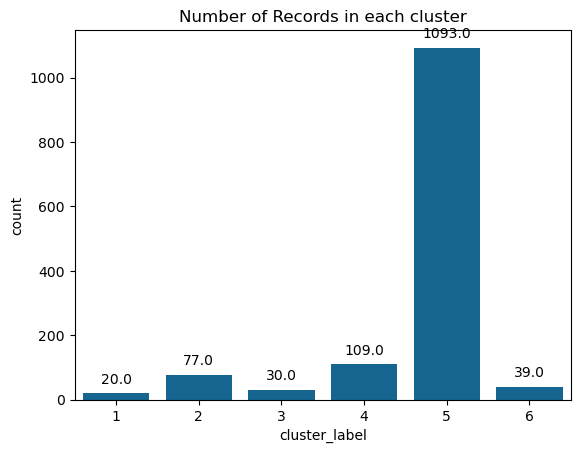

In [61]:
cluster_count_figure = sns.countplot(x='cluster_label', data = df)
for p in cluster_count_figure.patches:
    cluster_count_figure.annotate(format(p.get_height()),
                                  (p.get_x()+p.get_width()/2, 
                                   p.get_height()), 
                                  ha = 'center', 
                                  va = 'center', 
                                  xytext = (0, 10), 
                                  textcoords = 'offset points')

plt.title(label = f"Number of Records in each cluster")
plt.show()

### Kmeans: Topics within Each Cluster
[Return to Table of Contents](#Table-of-Contents)

After we assign the clusters to each record we can then investigate the score (i.e., TFIDF) of the top tokens in each cluster. This allows us to be able to see the tokens within each clusters, what are the scores, and extract some insights from such results. Note that in the case of Kmeans, there will always be one or two clusters with relatively low scores because Kmeans will force all records into one cluster regardless.

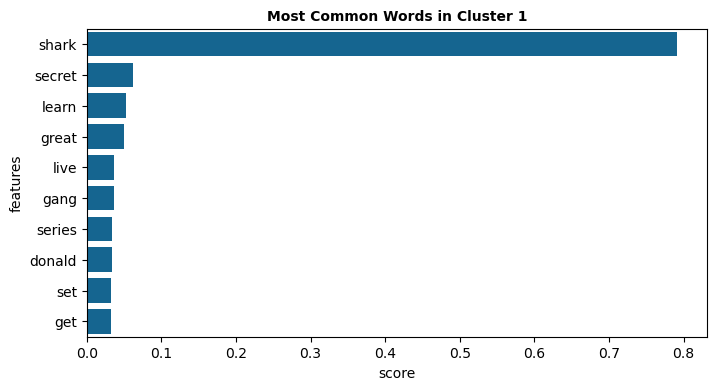

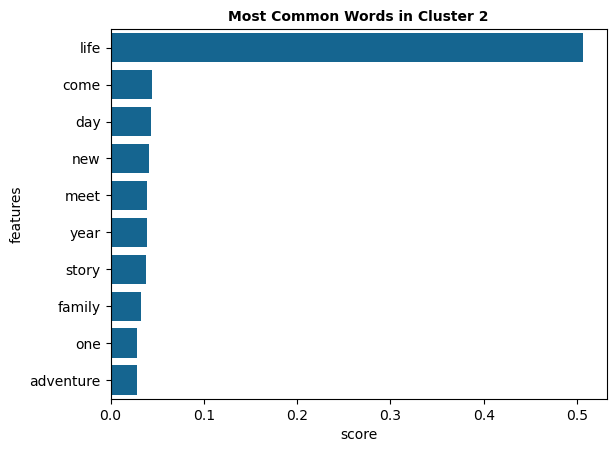

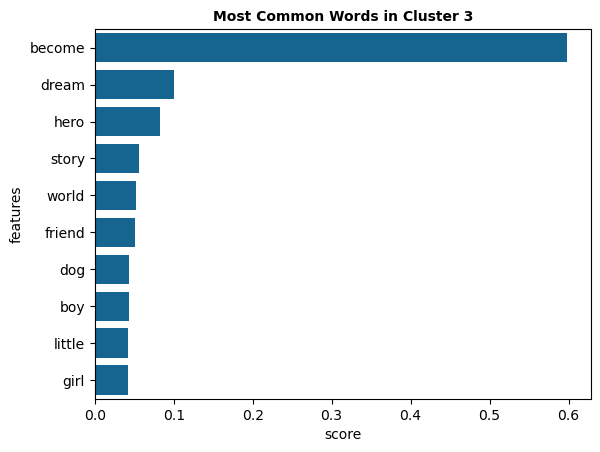

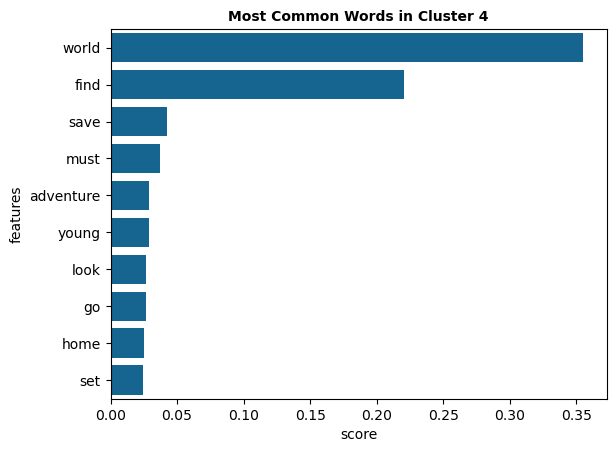

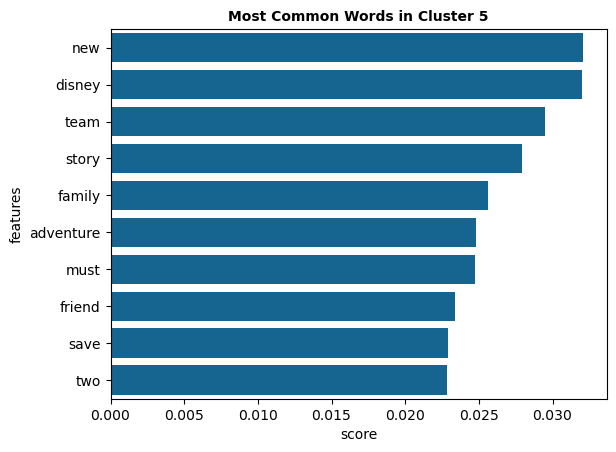

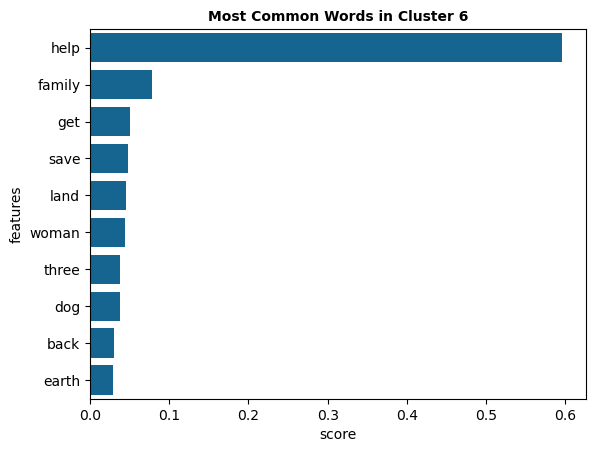

In [62]:
cluster_array = df["cluster_label"].to_numpy() # Converting cluster_label assigments to an array.
n_feats = 20
dfs = get_top_features_cluster(bow_array, cluster_array, n_feats) # Gets top n_feats (e.g., 20) from the BOW_array.
top_topics = 10
plotWords(dfs, top_topics) # Plots the top_topics up to n_feats.

After we have the clusters, we could also filter and obtain statistics for each cluster which may provide further insights.

# NOTEBOOK END